# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 10, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 10,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 50000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'early_stopping_patience': None,
        'batch_size': 256,
        'dense_layers': [8192, 4096],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 50000,
                
        'interpretation_net_output_monomials': 10, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': False, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 30,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 286
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 2, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 2, 0, 0, 0, 

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  2870


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense8192-4096-output_2870_drop0e2000b256_custom/lnets_50000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_50000_50-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_10_d_3_negd_0_prob_0_spars_10_amin_-1_amax_1_xdist_uniform_noise_normal_0


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  7.5min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
33553  1373158606              0.000              0.000              0.000   
9427   1373158606              0.000              0.000              0.000   
199    1373158606              0.000              0.000              0.000   
12447  1373158606              0.547              0.000              0.000   
39489  1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489             -0.630              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000              0.000              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000             -0.126              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489             -0.593              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
33553              0.000              0.000              0.000   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
33553             -0.404              0.000             -0.862   
9427               0.000              0.000              0.000   
199                0.000              0.000              0.000   
12447              0.000              0.000              0.000   
39489              0.000              

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  3000000000-target  2100000000-target  2010000000-target  \
count      50000.000          50000.000          50000.000          50000.000   
mean  1373158606.000              0.001              0.000              0.000   
std            0.000              0.108              0.109              0.107   
min   1373158606.000             -1.000             -0.999             -0.999   
25%   1373158606.000              0.000              0.000              0.000   
50%   1373158606.000              0.000              0.000              0.000   
75%   1373158606.000              0.000              0.000              0.000   
max   1373158606.000              0.999              0.998              0.999   

       2001000000-target  2000100000-target  2000010000-target  \
count          50000.000          50000.000          50000.000   
mean              -0.001             -0.000             -0.000   
std                0.107              0.107              0.107   
min               -0.996             -0.999             -1.000   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.999              1.000              1.000   

       2000001000-target  2000000100-target  2000000010-target  \
count          50000.000          50000.000          50000.000   
mean               0.001             -0.000             -0.000   
std                0.106              0.109              0.105   
min               -0.998             -1.000             -1.000   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.997              1.000              0.999   

       2000000001-target  2000000000-target  1200000000-target  \
count          50000.000          50000.000          50000.000   
mean              -0.000             -0.001             -0.001   
std                0.111              0.109              0.106   
min               -0.999             -0.997             -0.998   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                1.000              1.000              0.999   

       1110000000-target  1101000000-target  1100100000-target  \
count          50000.000          50000.000          50000.000   
mean               0.000              0.000              0.000   
std                0.109              0.109              0.109   
min               -0.999             -1.000             -1.000   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                0.999              0.999              0.998   

       1100010000-target  1100001000-target  1100000100-target  \
count          50000.000          50000.000          50000.000   
mean               0.000              0.000              0.001   
std                0.108              0.105              0.108   
min               -0.998             -1.000             -1.000   
25%                0.000              0.000              0.000   
50%                0.000              0.000              0.000   
75%                0.000              0.000              0.000   
max                1.000              1.000              0.999   

       1100000010-target  1100000001-target  1100000000-target  \
count          50000.000          50000.000          50000.000   
mean              -0.000              0.000              0.001   
std                0.112              0.108              0.108   
min               -1.000             -0.999    

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[7.05915157e-01, 6.27424136e-01, 2.31400764e-02, 3.69228633e-01,
        3.93976383e-01, 5.42979290e-01, 3.50559608e-01, 1.20249068e-01,
        8.87814480e-01, 1.84921226e-01],
       [3.66000488e-01, 4.22827881e-01, 4.73427194e-01, 4.76920219e-01,
        5.59645966e-01, 7.85109405e-01, 2.91205841e-01, 9.39370446e-01,
        4.06682111e-01, 3.24471608e-02],
       [4.09128828e-01, 1.53215290e-01, 2.35599972e-01, 9.95880126e-01,
        8.04528563e-01, 3.15136153e-01, 5.99134375e-01, 9.26189279e-01,
        1.55255961e-01, 9.49833970e-01],
       [8.15820084e-01, 8.53761090e-01, 5.96854502e-01, 4.66140691e-01,
        3.54703397e-01, 5.71349610e-01, 8.92274012e-01, 3.60118852e-02,
        5.97336602e-01, 5.18454712e-01],
       [8.25211803e-01, 6.81649808e-01, 8.32933068e-01, 2.84276584e-01,
        1.54202319e-01, 7.78798266e-01, 8.60080258e-01, 4.86106226e-01,
        3.62074064e-01, 9.99640259e-01],
       [8.54697269e-01, 8.95330725e-01, 6.67125320e-01, 2.52795799e-01,
   

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[ 0.05780073],
       [-0.55014724],
       [ 0.13309953],
       [-0.46402583],
       [-1.01678252],
       [-0.29628071],
       [-0.14892277],
       [ 0.48231304],
       [-0.67929465],
       [-0.20982581]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(44910, 1460)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(4990, 1460)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 1460)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
9901   1373158606              0.000              0.000              0.000   
5910   1373158606              0.000              0.000              0.000   
18619  1373158606              0.000              0.000              0.000   
33312  1373158606              0.284              0.000              0.000   
47430  1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.000   
47430              0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.462   
47430              0.000              0.000              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000             -0.586              0.000   
33312              0.000              0.000              0.000   
47430             -0.669              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000             -0.039   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.000   
47430              0.000              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.000   
47430              0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.083   
33312              0.000              0.000              0.000   
47430              0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.000   
47430              0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.000   
47430              0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
9901               0.000              0.000              0.000   
5910               0.000              0.000              0.000   
18619              0.000              0.000              0.000   
33312              0.000              0.000              0.000   
47430              0.000              

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
7038   1373158606              0.000              0.000              0.000   
30770  1373158606              0.000              0.000              0.000   
41342  1373158606              0.000              0.000              0.000   
21084  1373158606              0.000              0.000             -0.995   
47211  1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              0.000              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342             -0.198              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.106              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000             -0.865              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
7038               0.000              0.000              0.000   
30770              0.000              0.000              0.000   
41342              0.000              0.000              0.000   
21084              0.000              0.000              0.000   
47211              0.000              

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  3000000000-target  2100000000-target  2010000000-target  \
35587  1373158606              0.841              0.000              0.000   
32681  1373158606              0.494              0.000              0.000   
40971  1373158606              0.000              0.000              0.000   
21022  1373158606              0.000              0.000              0.000   
6403   1373158606              0.000              0.000              0.000   

       2001000000-target  2000100000-target  2000010000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971             -0.135              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       2000001000-target  2000000100-target  2000000010-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.971   
21022              0.000              0.000              0.000   
6403               0.000              0.354              0.000   

       2000000001-target  2000000000-target  1200000000-target  \
35587             -0.231              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1110000000-target  1101000000-target  1100100000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1100010000-target  1100001000-target  1100000100-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1100000010-target  1100000001-target  1100000000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971             -0.862              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1020000000-target  1011000000-target  1010100000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1010010000-target  1010001000-target  1010000100-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              0.000              0.000   

       1010000010-target  1010000001-target  1010000000-target  \
35587              0.000              0.000              0.000   
32681              0.000              0.000              0.000   
40971              0.000              0.000              0.000   
21022              0.000              0.000              0.000   
6403               0.000              

## Interpretation Network Training

In [23]:
%load_ext autoreload

In [24]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(601,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/2000
176/176 [==============================] - 144s 791ms/step - loss: 0.2763 - r2_inet_lambda_fv_loss: 0.1574 - val_loss: 0.2632 - val_r2_inet_lambda_fv_loss: 0.0424
Epoch 2/2000
176/176 [==============================] - 137s 781ms/step - loss: 0.2565 - r2_inet_lambda_fv_loss: -0.0190 - val_loss: 0.2540 - val_r2_inet_lambda_fv_loss: -0.0266
Epoch 3/2000
176/176 [==============================] - 139s 790ms/step - loss: 0.2523 - r2_inet_lambda_fv_loss: -0.0500 - val_loss: 0.2506 - val_r2_inet_lambda_fv_loss: -0.0565
Epoch 4/2000
176/176 [==============================] - 139s 790ms/step - loss: 0.2485 - r2_inet_lambda_fv_loss: -0.0780 - val_loss: 0.2563 - val_r2_inet_lambda_fv_loss: -0.0165
Epoch 5/2000
176/176 [==============================] - 139s 788ms/step - loss: 0.2499 - r2_inet_lambda_fv_loss: -0.0694 - val_loss: 0.2445 - val_r2_inet_lambda_fv_lo

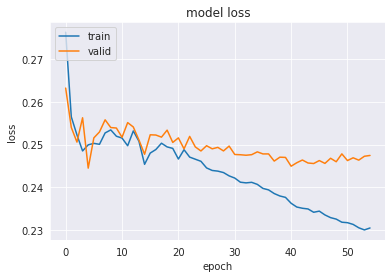

In [25]:
%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [26]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 601)]        0                                            
__________________________________________________________________________________________________
hidden1_8192 (Dense)            (None, 8192)         4931584     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 8192)         0           hidden1_8192[0][0]               
__________________________________________________________________________________________________
hidden2_4096 (Dense)            (None, 4096)         33558528    activation1_relu[0][0]           
______________________________________________________________________________________________

In [27]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [28]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [29]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload 2
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [35]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [36]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

In [37]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [38]:
#%load_ext autoreload

In [39]:
#%autoreload 2
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


False
metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:15
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished


In [40]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_inet_polynomials
Score Calculation Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


In [41]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [42]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [43]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 601)]        0                                            
__________________________________________________________________________________________________
hidden1_8192 (Dense)            (None, 8192)         4931584     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 8192)         0           hidden1_8192[0][0]               
__________________________________________________________________________________________________
hidden2_4096 (Dense)            (None, 4096)         33558528    activation1_relu[0][0]           
______________________________________________________________________________________________

In [44]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [45]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

In [46]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.102 0.145  9.607   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.184 0.244 17.170   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.102 0.145  1.894   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.225 0.290  6.079   
lstsq_target_polynomials_VS_inet_polynomials       0.184 0.244 17.170   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.356   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.191   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.356   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.150   
lstsq_target_polynomials_VS_inet_polynomials           0.191   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.025    0.033    0.623   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.032    0.042    0.955   
lambda_preds_VS_lstsq_target_polynomials             0.025    0.033    0.623   
lambda_preds_VS_inet_polynomials                     0.257    0.327    4.713   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.030    0.040    0.695   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials_VS_inet_polynomials               0.258    0.331    4.180   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.030    0.040    0.807   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.258    0.330    3.920   
lstsq_target_polynomials_VS_inet_polynomials         0.258    0.331    4.180   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.989    0.075    0.495   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.983    0.096    0.586   
lambda_preds_VS_lstsq_target_polynomials            0.989    0.075    0.495   
lambda_preds_VS_inet_polynomials                    0.082    0.746    2.855   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.985    0.088    0.549   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.000    0.000   
target_polynomials_VS_inet_polynomials              0.084    0.739    3.100   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.985    0.089    0.530   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.080    0.744    3.045   
lstsq_target_polynomials_VS_inet_polynomials   

In [47]:
distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values

array([0.28013164, 0.18306671, 0.19046599, 0.23417749, 0.2622867 ,
       0.22272846, 0.31433266, 0.18820938, 0.1822587 , 0.35898525,
       0.1882313 , 0.2413749 , 0.44510078, 0.25187406, 0.27125344,
       0.23842523, 0.2876356 , 0.34597516, 0.19411242, 0.15379314,
       0.33752915, 0.27616993, 0.21875821, 0.44015282, 0.16561967,
       0.20278347, 0.2383549 , 0.3632393 , 0.27929056, 0.26820555,
       0.3825519 , 0.19621032, 0.20395488, 0.26063716, 0.17825748,
       0.33165732, 0.26859137, 0.42781323, 0.2824877 , 0.35755092,
       0.33404773, 0.3300385 , 0.20942043, 0.18908805, 0.19334738,
       0.3613817 , 0.26377228, 0.23901714, 0.20261142, 0.18155329,
       0.12138242, 0.2709615 , 0.16377088, 0.25769275, 0.16925229,
       0.25128302, 0.2422955 , 0.19227867, 0.38644478, 0.24267781,
       0.39507622, 0.31599236, 0.33070353, 0.24502468, 0.19725882,
       0.21045068, 0.24974637, 0.28305718, 0.14952551, 0.2833144 ,
       0.21029487, 0.2321297 , 0.38604414, 0.18282256, 0.33330

In [48]:
distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values

array([ 0.22410508,  0.15232899,  0.44102698,  0.55480097,  0.00349087,
        0.16948038,  0.03842841,  0.26901833,  0.33441793, -0.15497731,
        0.33125203, -0.2654748 , -0.07314688,  0.36897504,  0.24965935,
       -0.02801358, -0.19000265, -0.19186384,  0.37280273,  0.25759635,
       -0.25820756,  0.38571249,  0.3741453 , -0.55829295,  0.28164177,
       -0.27601773,  0.27427824,  0.05999144,  0.08030632, -0.2850862 ,
       -0.18421349,  0.09635058,  0.20576495,  0.27210781,  0.17738596,
        0.09534599,  0.13183586, -0.29250087,  0.02743244, -0.08398357,
        0.05954469, -0.02257143,  0.32102493,  0.55205268,  0.34123551,
       -0.25401194, -0.0073613 ,  0.263577  ,  0.20713858,  0.3163906 ,
        0.28961388,  0.01987423,  0.23038972, -0.30400086,  0.08760728,
        0.13514115,  0.35361427,  0.46972075,  0.1035929 , -0.04577168,
       -0.12588356,  0.43101467, -0.56489347, -0.13370872,  0.19120901,
        0.33748578,  0.0523192 , -0.0153956 ,  0.29372284,  0.17

In [49]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.019 0.018 0.024 0.037   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.026 0.025 0.031 0.043   
lambda_preds_VS_lstsq_target_polynomials           0.019 0.018 0.024 0.037   
lambda_preds_VS_inet_polynomials                   0.280 0.183 0.190 0.234   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.022 0.022 0.030 0.045   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.280 0.183 0.192 0.236   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.022 0.022 0.030 0.045   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.281 0.185 0.189 0.236   
lstsq_target_polynomials_VS_inet_polynomials       0.280 0.183 0.192 0.236   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.022 0.026 0.022 0.024   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.030 0.032 0.033 0.031   
lambda_preds_VS_lstsq_target_polynomials           0.022 0.026 0.022 0.024   
lambda_preds_VS_inet_polynomials                   0.262 0.223 0.314 0.188   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.026 0.031 0.029 0.028   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.262 0.223 0.319 0.187   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.026 0.031 0.029 0.028   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.269 0.221 0.318 0.185   
lstsq_target_polynomials_VS_inet_polynomials       0.262 0.223 0.319 0.187   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.021 0.030 0.027 0.031   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.028 0.039 0.034 0.036   
lambda_preds_VS_lstsq_target_polynomials           0.021 0.030 0.027 0.031   
lambda_preds_VS_inet_polynomials                   0.182 0.359 0.188 0.241   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.025 0.034 0.032 0.039   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.183 0.362 0.190 0.245   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.025 0.034 0.032 0.039   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.185 0.361 0.190 0.244   
lstsq_target_polynomials_VS_inet_polynomials       0.183 0.362 0.190 0.245   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.040 0.019 0.032 0.020   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.049 0.027 0.039 0.027   
lambda_preds_VS_lstsq_target_polynomials           0.040 0.019 0.032 0.020   
lambda_preds_VS_inet_polynomials                   0.445 0.252 0.271 0.238   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.048 0.023 0.037 0.025   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.447 0.254 0.271 0.237   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.048 0.023 0.037 0.025   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.446 0.250 0.271 0.241   
lstsq_target_polynomials_VS_inet_polynomials       0.447 0.254 0.271 0.237   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.021 0.023 0.032 0.023   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.030 0.032 0.038 0.030   
lambda_preds_VS_lstsq_target_polynomials           0.021 0.023 0.032 0.023   
lambda_preds_VS_inet_polynomials                   0.288 0.346 0.194 0.154   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.029 0.029 0.035 0.026   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.291 0.346 0.198 0.

In [50]:
distrib_dict_test_list[-1]['R2']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.996 0.992 0.990 0.987   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.993 0.984 0.984 0.984   
lambda_preds_VS_lstsq_target_polynomials           0.996 0.992 0.990 0.987   
lambda_preds_VS_inet_polynomials                   0.224 0.152 0.441 0.555   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.995 0.988 0.985 0.982   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.235 0.160 0.435 0.557   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.995 0.987 0.985 0.981   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.221 0.150 0.443 0.548   
lstsq_target_polynomials_VS_inet_polynomials       0.235 0.160 0.435 0.557   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.993 0.988 0.995 0.988   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.986 0.981 0.990 0.978   
lambda_preds_VS_lstsq_target_polynomials           0.993 0.988 0.995 0.988   
lambda_preds_VS_inet_polynomials                   0.003 0.169 0.038 0.269   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.990 0.983 0.991 0.982   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.004 0.170 0.038 0.260   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.991 0.982 0.991 0.981   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.006 0.174 0.037 0.260   
lstsq_target_polynomials_VS_inet_polynomials       0.004 0.170 0.038 0.260   

                                                     L-8    L-9  L-10   L-11  \
lambda_preds_VS_target_polynomials                 0.990  0.990 0.984  0.977   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.983  0.985 0.977  0.968   
lambda_preds_VS_lstsq_target_polynomials           0.990  0.990 0.984  0.977   
lambda_preds_VS_inet_polynomials                   0.334 -0.155 0.331 -0.265   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.986  0.989 0.979  0.965   
target_polynomials_VS_lstsq_target_polynomials     1.000  1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials             0.330 -0.127 0.322 -0.264   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.986  0.988 0.979  0.963   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.324 -0.137 0.322 -0.285   
lstsq_target_polynomials_VS_inet_polynomials       0.330 -0.127 0.322 -0.264   

                                                     L-12  L-13  L-14   L-15  \
lambda_preds_VS_target_polynomials                  0.990 0.996 0.991  0.993   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.985 0.992 0.986  0.987   
lambda_preds_VS_lstsq_target_polynomials            0.990 0.996 0.991  0.993   
lambda_preds_VS_inet_polynomials                   -0.073 0.369 0.250 -0.028   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.986 0.993 0.987  0.989   
target_polynomials_VS_lstsq_target_polynomials      1.000 1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials             -0.077 0.366 0.248 -0.024   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.986 0.993 0.987  0.989   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.073 0.370 0.250 -0.033   
lstsq_target_polynomials_VS_inet_polynomials       -0.077 0.366 0.248 -0.024   

                                                     L-16   L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                  0.993  0.994 0.981 0.981   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.987  0.988 0.975 0.970   
lambda_preds_VS_lstsq_target_polynomials            0.993  0.994 0.981 0.981   
lambda_preds_VS_inet_polynomials                   -0.190 -0.192 0.373 0.258   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.987  0.990 0.979 0.979   
target_polynomials_VS_lstsq_target_polynomials      1.000  1.000 1.000 1.000   
target_polyno

In [51]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9511722733365922


0.039909537434154*a**3 + 0.0249793815898639*a**2*b + 0.0669647665205761*a**2*c - 0.021680556272731*a**2*d + 0.106780237253231*a**2*e - 0.0526275214663752*a**2*f + 0.0632145308519934*a**2*g - 0.300950923965637*a**2*h + 0.0181331045876663*a**2*i + 0.147463376795461*a**2*j - 0.178853346107507*a**2 + 0.101775655008799*a*b**2 + 0.0080806542441369*a*b*c - 0.0542395730574864*a*b*d + 0.0421122526064062*a*b*e + 0.0156902474841458*a*b*f - 0.0522172392023942*a*b*g - 0.0286905044605781*a*b*h + 0.055888542017871*a*b*i + 0.0098071681021546*a*b*j - 0.177179882521457*a*b + 0.179730766798587*a*c**2 + 0.0045556392218429*a*c*d + 0.0162122823095931*a*c*e + 0.0704612585899027*a*c*f + 0.0630022628584839*a*c*g + 0.151940788093253*a*c*h - 0.110601155027861*a*c*i + 0.111588959068109*a*c*j - 0.135730006973*a*c + 0.0684033822223163*a*d**2 - 0.0807091422090786*a*d*e - 0.0915116266900071*a*d*f - 0.272115517977629*a*d*g - 0.0550730477223712*a*d*h - 0.117101507711641*a*d*i + 0.0281043925126187*a*d*j - 0.105463444143

In [52]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.0824099161213401 (100 Samples)
Mean (only positive): 0.2111532267036646 (66 Samples)


In [53]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9828708557838496 (100 Samples)
Mean (only positive): 0.9828708557838496 (100 Samples)


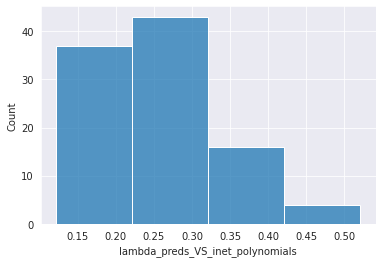

In [54]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

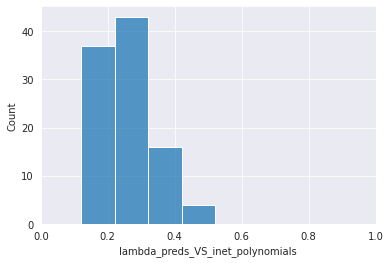

In [55]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


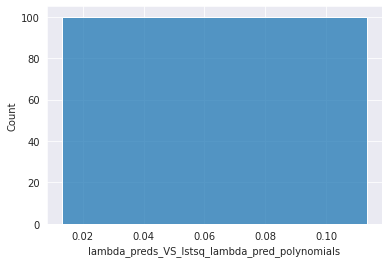

In [56]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

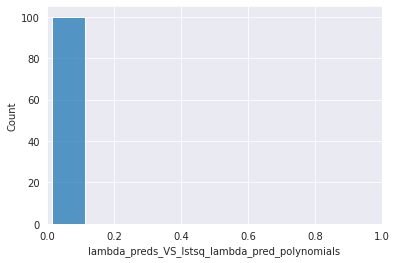

In [57]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


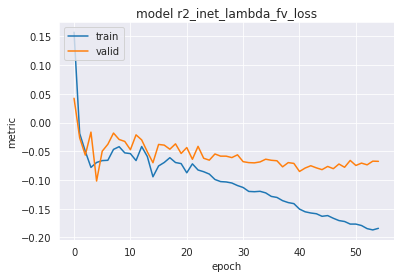

In [58]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


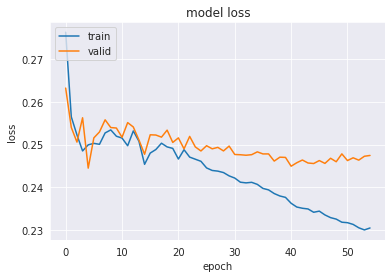

In [59]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [60]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [61]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [62]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [63]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.0284*a**3 - 0.0885*a**2*b - 0.1995*a**2*c + 0.0487*a**2*d - 0.0881*a**2*e + 0.0621*a**2*f + 0.0024*a**2*g - 0.484*a**2*h - 0.0603*a**2*i - 0.0997*a**2*j + 0.1031*a**2 + 0.0421*a*b**2 + 0.1324*a*b*c - 0.1659*a*b*d + 0.0753*a*b*e + 0.0199*a*b*f - 0.1077*a*b*g + 0.0172*a*b*h - 0.1126*a*b*i + 0.0218*a*b*j + 0.095*a*b - 0.1197*a*c**2 - 0.0837*a*c*d + 0.079*a*c*e - 0.2546*a*c*f - 0.1474*a*c*g + 0.0753*a*c*h - 0.0354*a*c*i - 0.19*a*c*j + 0.5301*a*c + 0.0041*a*d**2 + 0.0017*a*d*e + 0.0779*a*d*f - 0.0019*a*d*g - 0.0532*a*d*h + 0.0505*a*d*i - 0.0375*a*d*j + 0.0741*a*d - 0.1675*a*e**2 - 0.0971*a*e*f - 0.1863*a*e*g + 0.0965*a*e*h + 0.0658*a*e*i + 0.8056*a*e*j + 0.2714*a*e + 0.0469*a*f**2 + 0.1344*a*f*g - 0.4521*a*f*h + 0.0506*a*f*i - 0.347*a*f*j - 0.14*a*f + 0.1963*a*g**2 - 0.1123*a*g*h - 0.0135*a*g*i - 0.1998*a*g*j + 0.1396*a*g - 0.228*a*h**2 + 0.0072*a*h*i - 0.0738*a*h*j + 0.0296*a*h - 0.0821*a*i**2 + 0.0696*a*i*j + 0.1039*a*i + 0.0059*a*j**2 + 0.3538*a*j - 0.3974*a - 0.0048*b**3 - 0.05*b**2*c

[ 2.83946667e-02 -8.84516103e-02 -1.99510202e-01  4.86579452e-02
 -8.81108537e-02  6.20501467e-02  2.36221978e-03 -4.83960403e-01
 -6.02561441e-02 -9.96602306e-02  1.03144186e-01  4.21188691e-02
  1.32408604e-01 -1.65901892e-01  7.52724064e-02  1.98843000e-02
 -1.07671301e-01  1.71815214e-02 -1.12576465e-01  2.17807088e-02
  9.49851329e-02 -1.19667970e-01 -8.36969602e-02  7.89749968e-02
 -2.54632671e-01 -1.47400341e-01  7.52902225e-02 -3.54337744e-02
 -1.90028051e-01  5.30124794e-01  4.14326019e-03  1.73036031e-03
  7.78785442e-02 -1.90340612e-03 -5.32388550e-02  5.04751545e-02
 -3.74670277e-02  7.40827893e-02 -1.67462231e-01 -9.70712071e-02
 -1.86311912e-01  9.64663774e-02  6.58402751e-02  8.05586549e-01
  2.71439019e-01  4.68976045e-02  1.34406716e-01 -4.52122460e-01
  5.06465995e-02 -3.46987999e-01 -1.39975391e-01  1.96322317e-01
 -1.12325250e-01 -1.34522967e-02 -1.99792239e-01  1.39645694e-01
 -2.28045318e-01  7.19329534e-03 -7.37845713e-02  2.95515079e-02
 -8.21238030e-02  6.96261

-0.6039*a**2*h + 0.9625*a*e*j - 0.6174*a*f*h - 0.3853*a*f*j - 0.8246*c*h*j + 0.0663*d*e**2 + 0.3537*d*g*h + 0.096*f*g**2 - 0.6667*g*h*i - 0.932*g*h

[ 1.48877656e-08  1.31432497e-08 -3.65014817e-08  2.99025592e-08
 -4.74102848e-08 -1.19048743e-08 -2.08858703e-08 -6.03878426e-01
  3.03796203e-08 -1.41287709e-08 -1.04668793e-09  3.10161492e-08
 -1.42105018e-08  2.80377331e-08  2.97706919e-08 -1.72428329e-08
  2.28683106e-08 -3.30013860e-08 -2.32928143e-08  2.35084538e-08
 -5.50079088e-08  1.43140827e-08  2.31866080e-08 -6.69884538e-08
 -9.00490918e-09 -1.20933793e-08  5.66028977e-08  1.15512542e-07
  5.48993365e-08 -4.51639854e-08  2.43748828e-08 -5.65806936e-08
 -6.87815561e-10 -5.25617486e-09  3.89070119e-08 -7.21978762e-08
  4.52583433e-08 -5.28692304e-08 -5.84084194e-08 -1.00402777e-08
 -4.28438842e-08  9.97407076e-09 -1.67885817e-08  9.62532124e-01
  1.88525512e-07  1.90769229e-08 -4.17848437e-08 -6.17430563e-01
  2.51885059e-08 -3.85265373e-01  3.89859881e-08 -5.29652443e-09
 -3.31336197e-08  2.17805802e-08  8.06297582e-08  1.94283580e-08
  1.94832936e-08 -1.83246396e-08  6.99835186e-08 -7.02739851e-08
 -1.04417021e-08 -2.15915

-0.6039*a**2*h + 0.9625*a*e*j - 0.6174*a*f*h - 0.3853*a*f*j - 0.8246*c*h*j + 0.0663*d*e**2 + 0.3537*d*g*h + 0.096*f*g**2 - 0.6667*g*h*i - 0.932*g*h

[ 0.          0.          0.          0.          0.          0.
  0.         -0.60387844  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.96253214  0.          0.          0.         -0.61743057
  0.         -0.38526536  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

-0.175500005483627*a**3 - 0.256999999284744*a**2 - 0.211999997496605*a*b - 0.2567999958992*a*i*j - 0.41100001335144*c*d + 0.000899999984540045*d**3 - 0.195800006389618*d*g**2 - 0.166999995708466*e**2*f + 0.0753000006079674*e - 0.236699998378754*g*h*j

[ 0.07529496 -0.25701344 -0.41102973 ...  0.00353586  0.00363184
  0.00384689]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


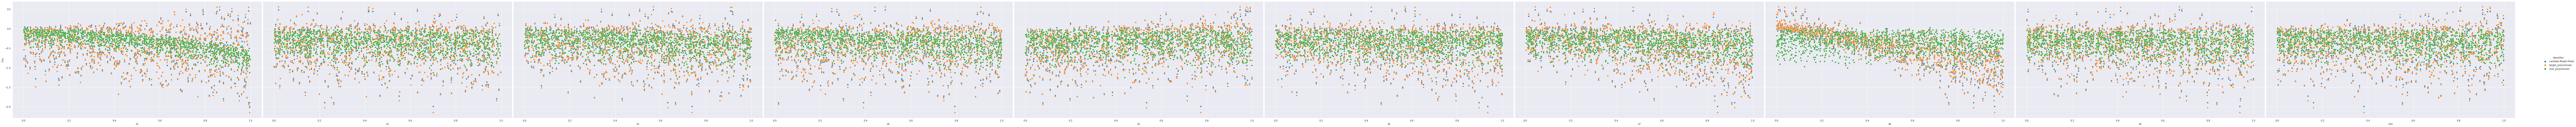

In [64]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

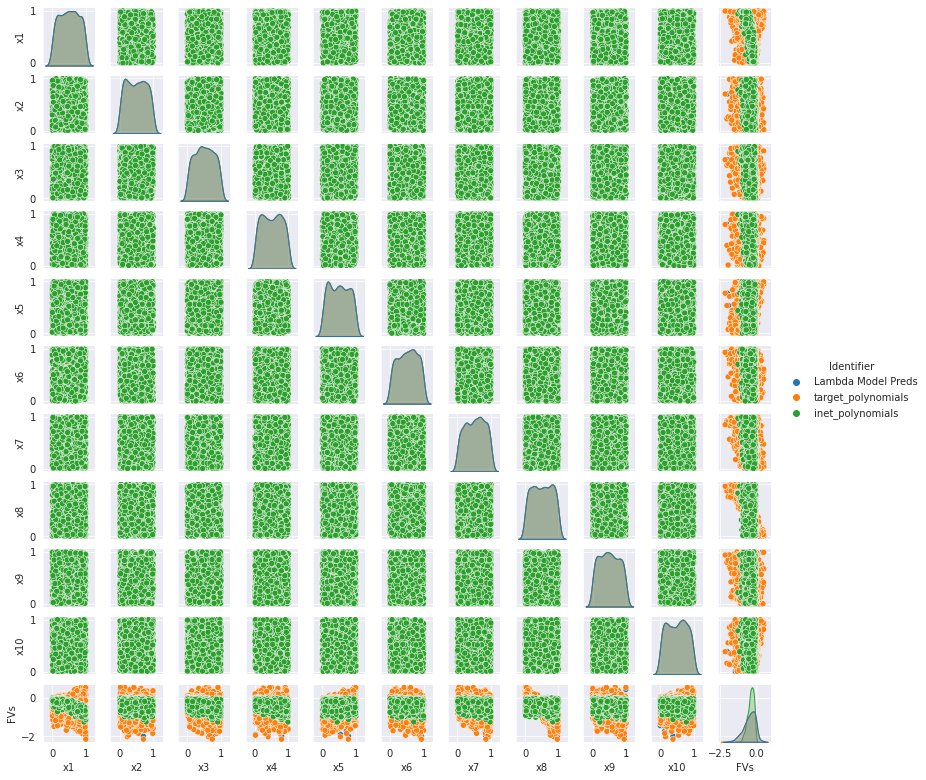

In [65]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

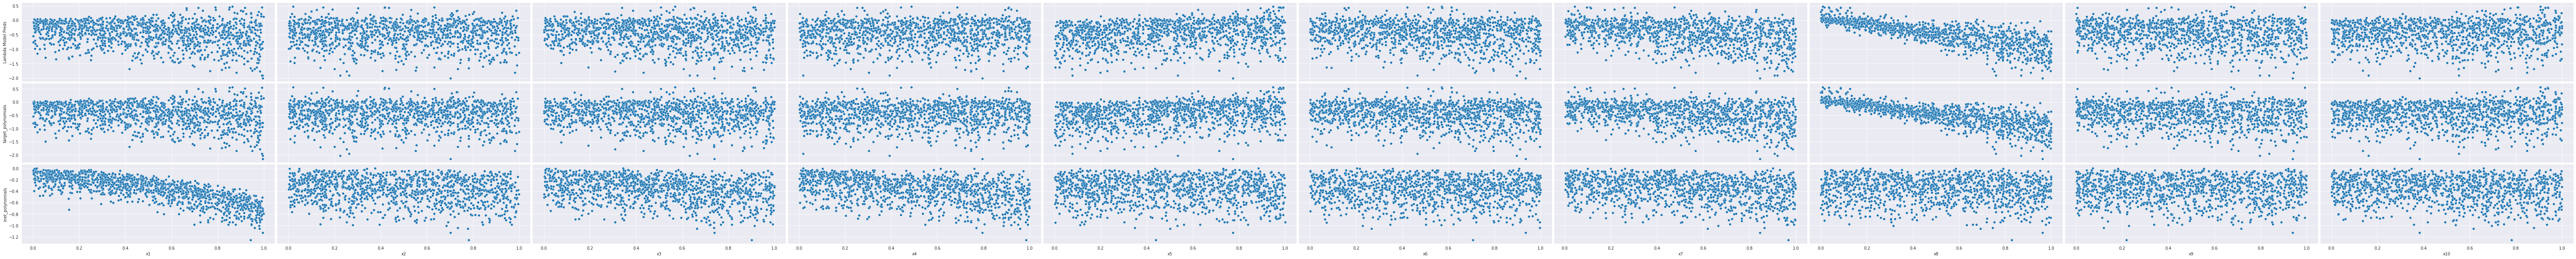

In [66]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [67]:
STOP

NameError: name 'STOP' is not defined

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()